In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = SparkSession.builder.appName('2021EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [5]:
df_2021 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2021", inferSchema=True, header=True)
# figure out how to read in shp file msca-bdp-student-gcs/bdp-rideshare-project/neighborhoods/shp files
df_weather = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/weather/chicago 2020-01-01 to 2022-08-31.csv", inferSchema=True, header=True)
df_2021.printSchema()
df_weather.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tip: integer (nullable = true)
 |-- Additional Charges: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Shared Trip Authorized: boolean (nullable = true)
 |-- Trips Pooled: integer (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid Longitude: double (nullable = true)
 |-- Dropof

In [5]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2021.rdd.getNumPartitions()

99

In [6]:
displaypartitions(df_2021)

Partitions: 99


+-----------+------+
|partitionId| count|
+-----------+------+
|         98|247115|
|         78|503687|
|         92|504130|
|         85|507725|
|         69|508327|
|         83|508472|
|         80|508483|
|         89|508726|
|         90|509264|
|         71|509326|
|         73|509865|
|         76|509943|
|         82|510114|
|         67|511481|
|         94|512490|
|         75|512592|
|         91|512824|
|         41|513552|
|         95|513946|
|         45|514289|
|         84|514945|
|         77|515161|
|         53|515174|
|         70|515754|
|         49|515909|
|         63|515916|
|         93|516070|
|         51|516100|
|         74|516196|
|         65|516213|
|         66|516473|
|         43|516499|
|         81|516882|
|         64|517161|
|         61|517254|
|         87|517327|
|         39|517434|
|         47|517452|
|         88|517511|
|         34|517740|
|         72|518066|
|         79|518108|
|         62|518477|
|         86|518712|
|         68|

In [67]:
# df_2021 = df_2021.repartition(10)

In [7]:
df_2021.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+-----------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+------------------+-----------------+--------------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|summary|             Trip ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|       Trip Miles| Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|              Fare|               Tip|Additional Charges|       Trip Total|        Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+--------------------+--------------------+------------------+-------------

In [8]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
df_2021.select([count(when(df_2021[c].isNull(), c)).alias(c) for c in df_2021.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+-----+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area| Fare|  Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+-----+-----+------------------+----------+-------------

<AxesSubplot:>

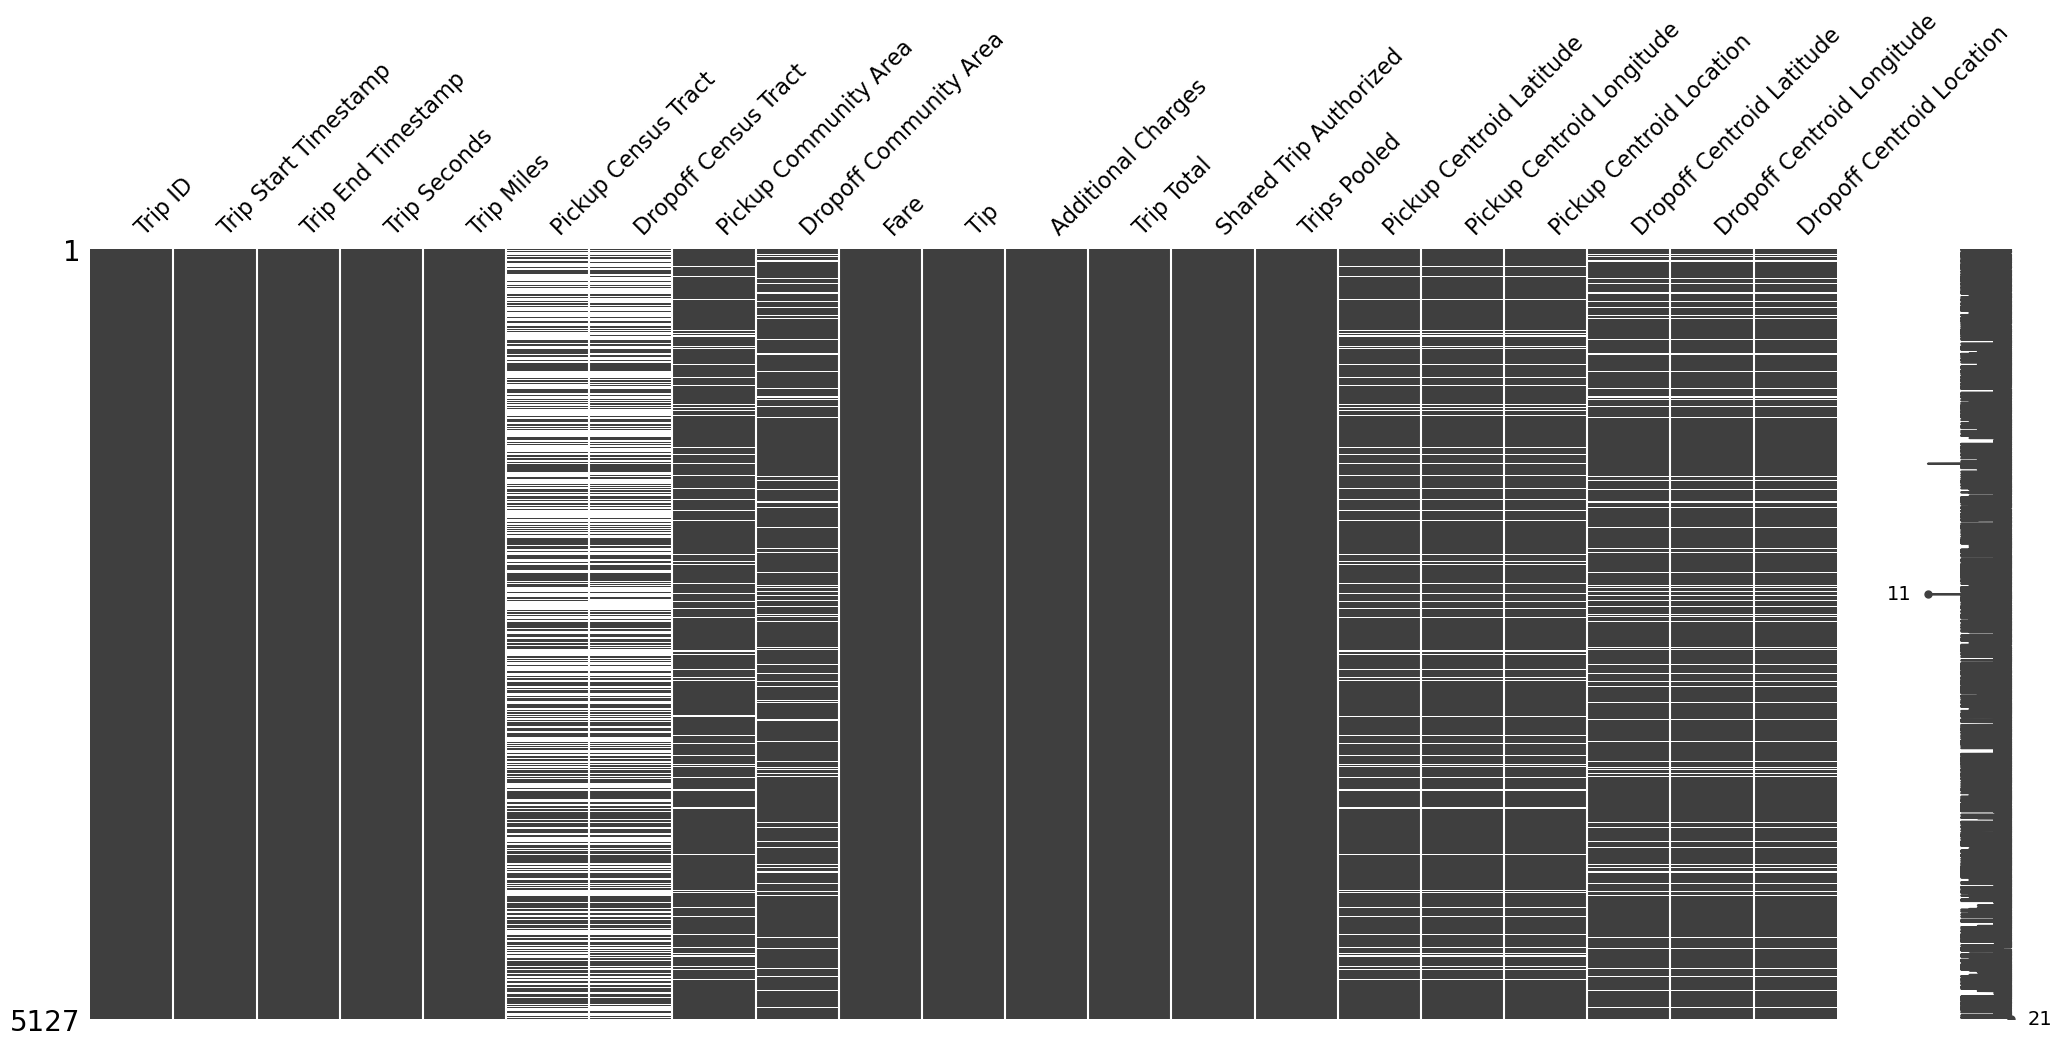

In [7]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2021.sample(fraction=1/10000).toPandas())

In [10]:
#Approximate number of 2021 trips
from pyspark.sql.functions import approxCountDistinct

df_2021.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/12 23:22:47 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+
|approx_count_distinct(Trip ID)|
+------------------------------+
|                      51541076|
+------------------------------+



In [11]:
# number of observations with all the data in each column
df_2021.dropna(how='any').count()

23351507

In [6]:
# Working with just data that contains full information and check for dupes
df_2021 = df_2021.dropna(how='any', subset=['Trip Start Timestamp','Trip End Timestamp','Fare','Dropoff Community Area','Pickup Community Area'])
df_2021 = df_2021.dropDuplicates()

In [7]:
# Drop columns unlikely to be useful for analysis for speed of computation and rename columns to remove spacing for ease of code writing
df_2021 = df_2021.drop('Trips Pooled','Additional Charges','Shared Trip Authorized','Pickup Centroid Location','Dropoff Centroid Location')
df_2021 = df_2021.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Location","dropoff_location").withColumnRenamed("Trip Seconds","seconds")
# fix datatypes
df_2021 = df_2021.withColumn('start_timestamp', F.to_timestamp(df_2021['start_timestamp'], 'MM/dd/yyyy hh:mm:ss a')).withColumn('end_timestamp', F.to_timestamp(df_2021['end_timestamp'], 'MM/dd/yyyy hh:mm:ss a'))
df_weather = df_weather.withColumn('datetime',F.to_date(df_weather['datetime'], "yyyy-MM-dd"))


In [8]:
# add the month column
df_2021 = df_2021.withColumn('month', F.month(df_2021.start_timestamp))
df_2021 = df_2021.withColumn('day_of_month', F.dayofmonth(df_2021.start_timestamp))
df_2021 = df_2021.withColumn('hour', F.hour(df_2021.start_timestamp))
df_2021 = df_2021.withColumn('day', F.dayofweek(df_2021.start_timestamp))
df_2021.show(3)

+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|                  ID|    start_timestamp|      end_timestamp|seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|   pickup_lat|    pickup_lon|  dropoff_lat|   dropoff_lon|month|day_of_month|hour|day|
+--------------------+-------------------+-------------------+-------+-----+------------+-------------+-----------+------------+----+---+-----+-------------+--------------+-------------+--------------+-----+------------+----+---+
|76d913bb3f0771ab2...|2021-01-01 00:00:00|2021-01-01 00:15:00|   1039|  5.9|        null|         null|         44|          39|20.0|  0|21.23|41.7402057565|-87.6159695226|41.8089162826|-87.5961833442|    1|           1|   0|  6|
|6ebae7e105b93a085...|2021-01-01 00:15:00|2021-01-01 00:15:00|    285|  2.4| 170

In [16]:
sample_df = df_2021.sample(fraction=1/10000).toPandas().loc[:,["pickup_area","dropoff_area","total","Fare","Tip","total","miles","seconds","hour","day","month"]]

In [17]:
sample_df.dtypes

pickup_area       int32
dropoff_area      int32
total           float64
Fare            float64
Tip               int32
total           float64
miles           float64
seconds         float64
hour              int32
day               int32
month             int32
dtype: object

In [19]:
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

In [20]:
sample_df.head()
sample_df = sample_df.drop(columns='total')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.pairplot(sample_df, hue='dropoff_area')
plt.show()

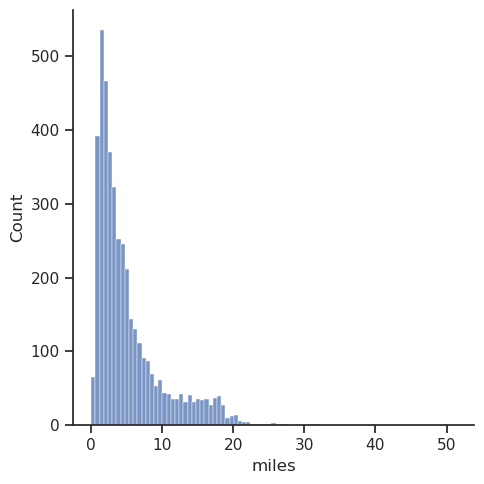

In [24]:
sns.displot(sample_df, x="miles")

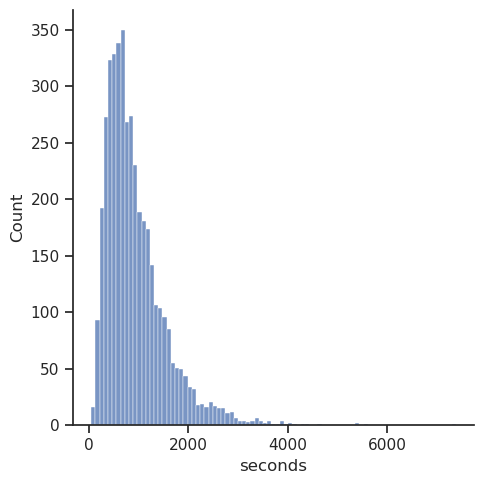

In [26]:
sns.displot(sample_df, x="seconds")

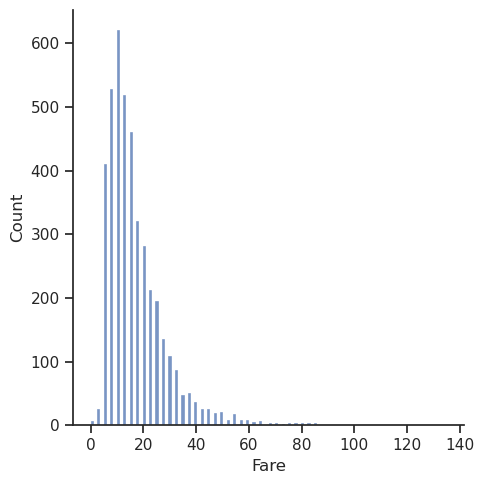

In [27]:
sns.displot(sample_df, x="Fare")

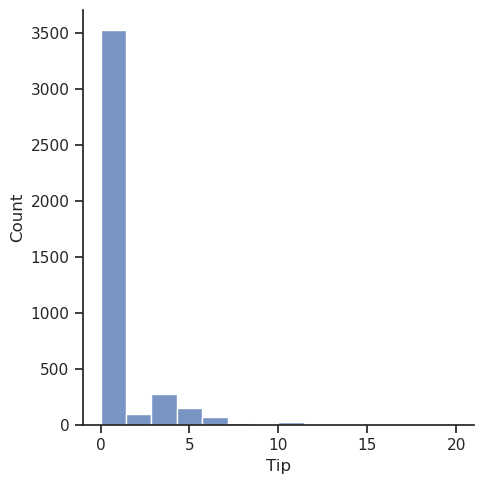

In [28]:
sns.displot(sample_df, x="Tip")

In [23]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2021.filter((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 41))
df_kw = df_2021.filter(((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 42)) | ((df_2021.pickup_area == 42) & (df_2021.dropoff_area == 41)))
df_wl = df_2021.filter(((df_2021.pickup_area == 41) & (df_2021.dropoff_area == 39)) | ((df_2021.pickup_area == 39) & (df_2021.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

In [17]:
df_area.show(5)

+--------------------+-------------------+-------------------+------------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+----+
|                  ID|    start_timestamp|      end_timestamp|Trip Seconds|miles|pickup_tract|dropoff_tract|pickup_area|dropoff_area|Fare|Tip|total|  pickup_lat|   pickup_lon| dropoff_lat|  dropoff_lon|month|hour|
+--------------------+-------------------+-------------------+------------+-----+------------+-------------+-----------+------------+----+---+-----+------------+-------------+------------+-------------+-----+----+
|18ebf670b1e3b6edc...|2021-01-01 03:00:00|2021-01-01 03:00:00|         403|  0.9|        null|         null|         41|          41| 5.0|  0| 9.01|41.794090253|-87.592310855|41.794090253|-87.592310855|    1|   3|
|e58f4477036633ebe...|2021-01-02 19:00:00|2021-01-02 19:00:00|         209|  0.7|        null|         null|         41|          41| 2.5|  0|  

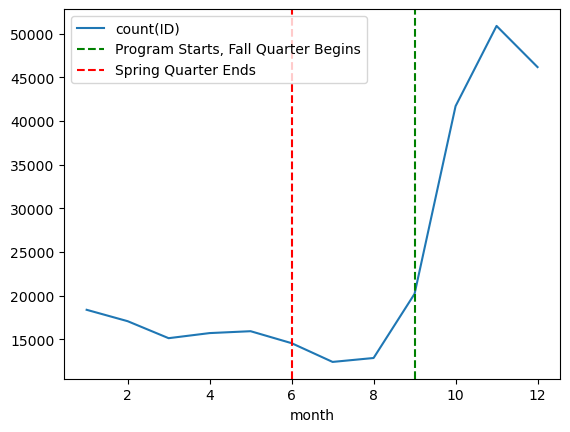

In [23]:
import matplotlib.pyplot as plt
df_count_plot = df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas() #.plot(x="month",y="count(ID)")
ax = df_count_plot.plot(x="month", y="count(ID)")
ax.axvline(x=9, color='g', linestyle='--', label='Program Starts, Fall Quarter Begins')
ax.axvline(x=6, color='r', linestyle='--', label='Spring Quarter Ends')
plt.legend()
plt.show()

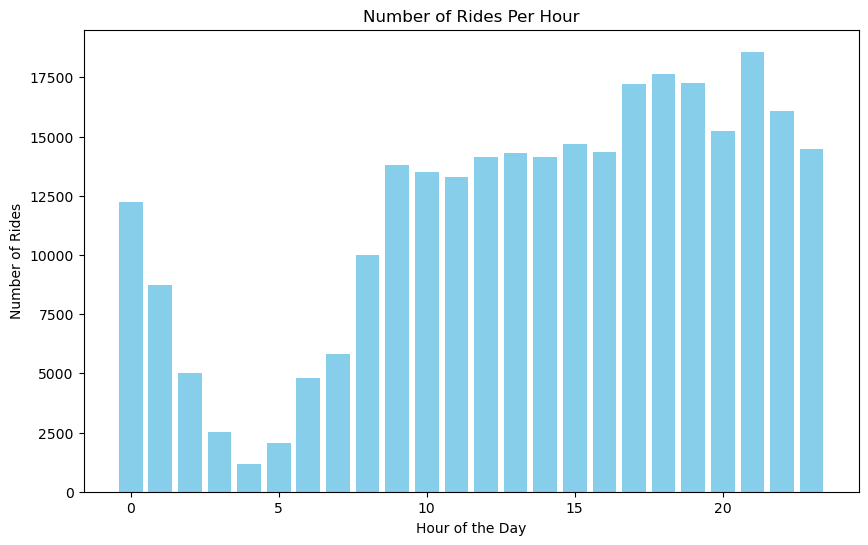

In [19]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

In [24]:
# verify this is the correct time period for your given year
df_area_program_1 = df_area.filter((df_area.Fare <= 15.0) & ((df_area.hour >= 21) | (df_area.hour < 4)) & ((df_area.day >= 3) & (df_area.day < 6)) & ((df_area.month == 10) | ((df_area.month == 11) & (df_area.day_of_month < 11))))
df_area_program_2 = df_area.filter((df_area.Fare <= 15.0) & ((df_area.hour >= 17) | (df_area.hour < 4)) & ((df_area.month == 12) | ((df_area.month == 11) & (df_area.day_of_month > 11))))
df_area_program = df_area_program_1.union(df_area_program_2)

If I actually do the above filter ^^ the the how will I filter during the pre-program period? I thought the graph was a nice demonstration of the change

In [25]:
from pyspark.sql.functions import approxCountDistinct

df_area_program.select(approxCountDistinct("ID", rsd = 0.20)).show()

+-------------------------+
|approx_count_distinct(ID)|
+-------------------------+
|                    36889|
+-------------------------+



23/11/16 01:18:12 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 1 for reason Container marked as failed: container_1700094704615_0002_01_000001 on host: hub-msca-bdp-dphub-students-abejburton-sw-w0bj.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
23/11/16 01:18:12 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 1 on hub-msca-bdp-dphub-students-abejburton-sw-w0bj.c.msca-bdp-student-ap.internal: Container marked as failed: container_1700094704615_0002_01_000001 on host: hub-msca-bdp-dphub-students-abejburton-sw-w0bj.c.msca-bdp-student-ap.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


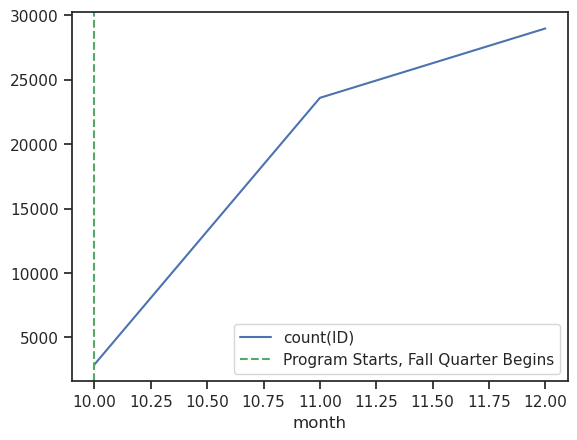

In [27]:
df_count_plot_program = df_area_program.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas() #.plot(x="month",y="count(ID)")
ax = df_count_plot_program.plot(x="month", y="count(ID)")
ax.axvline(x=10, color='g', linestyle='--', label='Program Starts, Fall Quarter Begins')
#ax.axvline(x=6, color='r', linestyle='--', label='Spring Quarter Ends')
plt.legend()
plt.show()

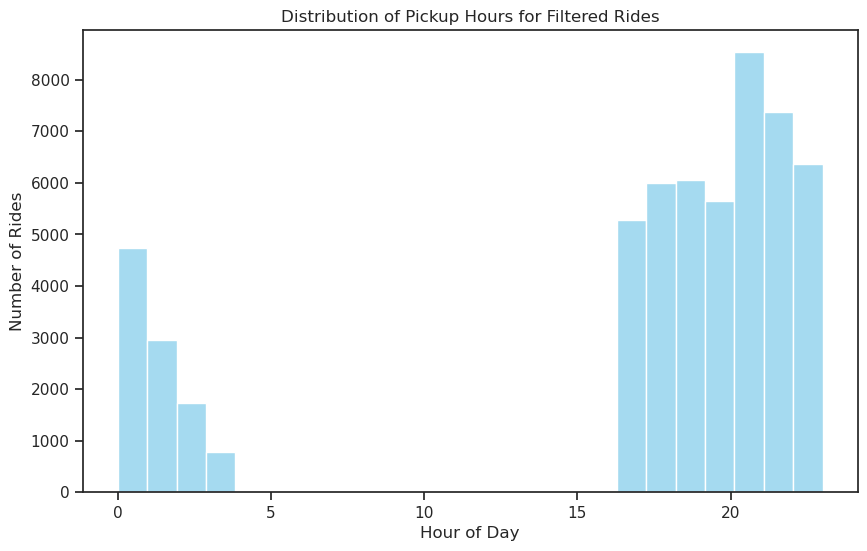

In [28]:
import seaborn as sns

df_area_program_pd = df_area_program.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_area_program_pd['hour'], bins=24, kde=False, color='skyblue')
plt.title('Distribution of Pickup Hours for Filtered Rides')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

<AxesSubplot:xlabel='month'>

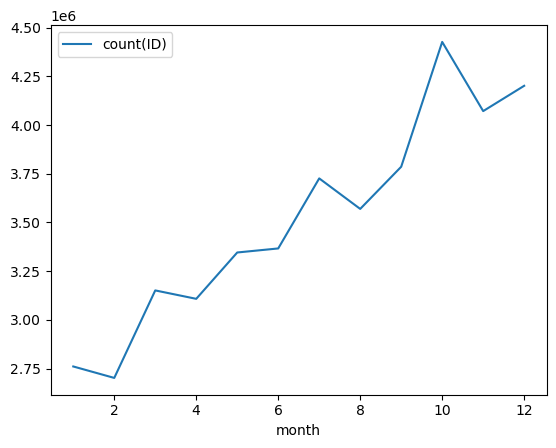

In [31]:
# basic plots for all rides (not just in the program area)
df_2021.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

In [35]:
df_total = df_2021.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas()

<Figure size 1000x1000 with 0 Axes>

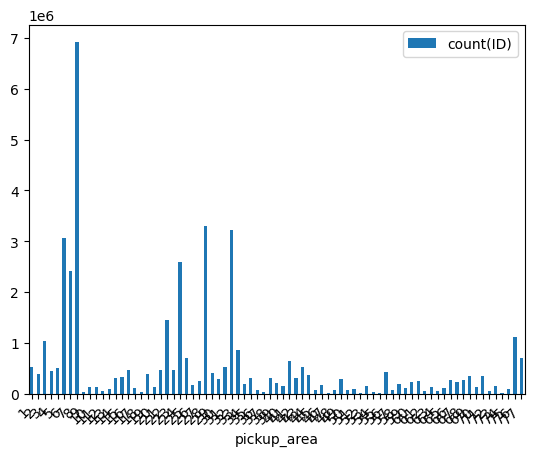

In [41]:
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = df_total.plot(x="pickup_area",y="count(ID)", kind='bar')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

<AxesSubplot:xlabel='dropoff_area'>

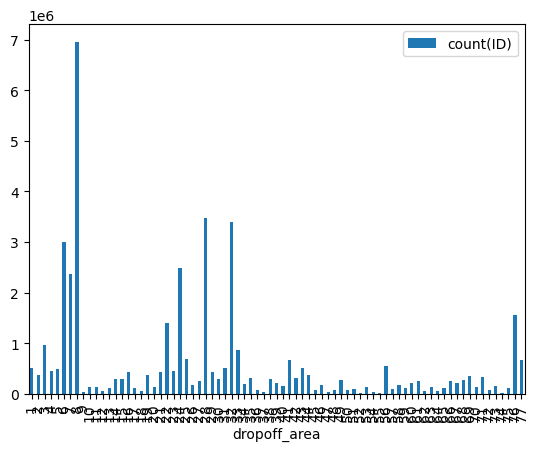

In [43]:
df_2021.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="dropoff_area",y="count(ID)", kind='bar')

In [29]:
# storing data on the bucket
df_area_program.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2021.csv")
df_2021.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2021.csv")

